In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import Audio

from dataset import AudioUtils
from utils import plot_label_distribution, plot_audio_waveform, plot_audio_spectogram

In [2]:
DATA_PATH = 'data'
METADATA_FILE = 'data/metadata_compiled.csv'

In [3]:
metadata_df = pd.read_csv(METADATA_FILE)

# Part 1: Explore the dataset through code

## a. How many samples does the dataset contain?

In [4]:
sample_count = metadata_df.shape[0]
labbled_count = metadata_df[metadata_df['status'].notna()].shape[0]
unlabelled_count = metadata_df[metadata_df['status'].isna()].shape[0]

print(f'Dataset contains {sample_count} samples in total. However out of those only {labbled_count} are labeled and {unlabelled_count} are unlabeled.')

Dataset contains 27550 samples in total. However out of those only 16224 are labeled and 11326 are unlabeled.


## b. How many classes? How many images per class? Show a histogram of the number of instances per class.

In [5]:
print('Columns in metadata file:', len(metadata_df.columns))
metadata_df.columns

Columns in metadata file: 51


Index(['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
       'quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1',
       'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1',
       'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2',
       'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2',
       'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3',
       'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3',
       'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4',
       'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4'],
      dtype='object')

From the 51 columns we only focused on the `status` column. We can see that there are 3 classes (`healthy`, `symptomatic` and `COVID-19`) in the dataset.

In [6]:
metadata_df['status'].value_counts()

healthy        12479
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64

The number of images per class is shown in the histogram below.

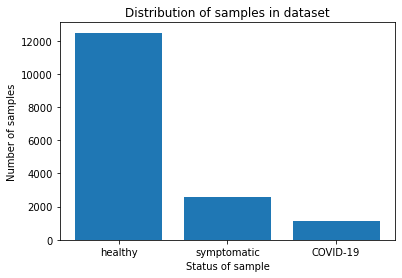

In [7]:
plot_label_distribution(metadata_df['status'].value_counts(), title='Distribution of samples in dataset')

## c. Play a random sample from each class.

### Healthy sample

Loaded sample with sample rate 48000 Hz and duration 8.70 seconds.


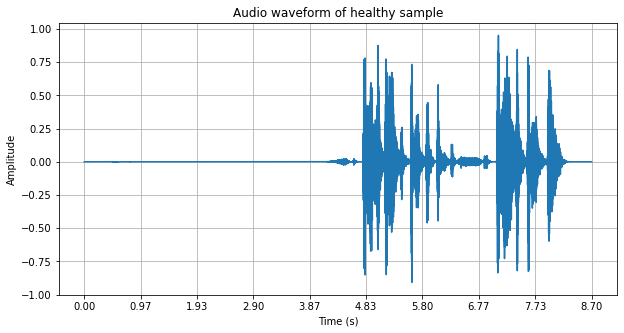

In [8]:
healty_sample_uuid = random.choice(metadata_df[metadata_df['status'] == 'healthy']['uuid'].to_list())
signal, sample_rate, info = AudioUtils.load_audio_file(healty_sample_uuid, DATA_PATH)

print(f'Loaded sample with sample rate {sample_rate} Hz and duration {info.num_frames / info.sample_rate:.2f} seconds.')

plot_audio_waveform(signal, sample_rate, title='Audio waveform of healthy sample')

Audio(signal, rate=sample_rate, embed=True)

### Symptomatic sample

Loaded sample with sample rate 48000 Hz and duration 5.70 seconds.


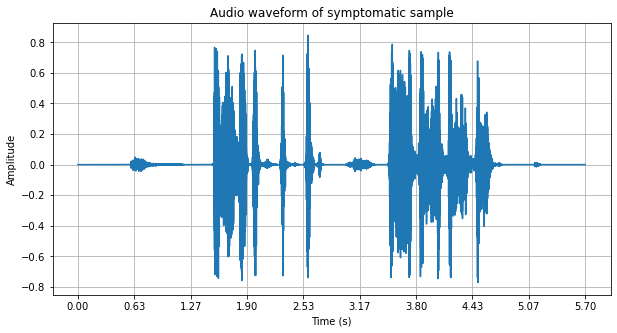

In [9]:
symptomatic_sample_uuid = random.choice(metadata_df[metadata_df['status'] == 'symptomatic']['uuid'].to_list())
signal, sample_rate, info = AudioUtils.load_audio_file(symptomatic_sample_uuid, DATA_PATH)

print(f'Loaded sample with sample rate {sample_rate} Hz and duration {info.num_frames / info.sample_rate:.2f} seconds.')

plot_audio_waveform(signal, sample_rate, title='Audio waveform of symptomatic sample')

Audio(signal, rate=sample_rate, embed=True)

### COVID-19 sample

Loaded sample with sample rate 48000 Hz and duration 9.90 seconds.


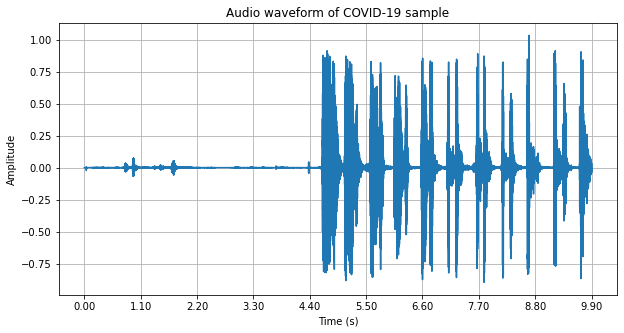

In [10]:
covid_sample_uuid = random.choice(metadata_df[metadata_df['status'] == 'COVID-19']['uuid'].to_list())
signal, sample_rate, info = AudioUtils.load_audio_file(covid_sample_uuid, DATA_PATH)

print(f'Loaded sample with sample rate {sample_rate} Hz and duration {info.num_frames / info.sample_rate:.2f} seconds.')

plot_audio_waveform(signal, sample_rate, title='Audio waveform of COVID-19 sample')

Audio(signal, rate=sample_rate, embed=True)

## d. Describe if/how you think the data distribution will affect training of a classifier.

The data-set distribution is unequal for the three different classes as there is a significantly greater amount of healthy data points than with covid and symptomatic. This could potentially affect the training of the classifier and skew the rewards towards detecting healthy more often than it should.

## e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice.

During the training, we selected the samples where the status value was labeled by a professional manually and set a threshold for the cough detected value. During the training, we tried different threshold values from `0.6` to  `0.9`. We kept all three status labels `healthy`, `symptomatic`, and `COVID-19`. (You can see the distribution of the labels in the histogram below.)

Because of the high percentage of `healthy` labels in the dataset, most of our models overfitted for the `healthy` label and only predicted `healthy` labels. That is why we always got `~75%` accuracy which is the same amount as the `healthy` labels in the dataset.

We reduced the number of `healthy` and `symptomatic` labels to equalize the number of the samples by the class to avoid predicting only `healthy` labels. However if we were to just equalize across all classes we would only have around ¬700 samples available for each class for training, testing and validation which is why we implemented some data augumentation which can be seen in the augmentation appendix.

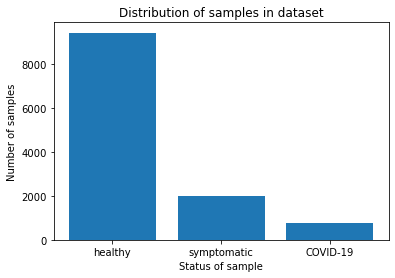

In [11]:
COUGH_DETECTED_THRESHOLD = 0.6
filtered_df = metadata_df[metadata_df['cough_detected'] > COUGH_DETECTED_THRESHOLD]

plot_label_distribution(filtered_df['status'].value_counts(), title='Distribution of samples in dataset')

In [12]:
covid_samples_count = filtered_df[filtered_df['status'] == 'COVID-19'].shape[0]

equalized_df = pd.concat([
    filtered_df[filtered_df['status'] == 'healthy'].sample(n=covid_samples_count, random_state=42),
    filtered_df[filtered_df['status'] == 'symptomatic'].sample(n=covid_samples_count, random_state=42),
    filtered_df[filtered_df['status'] == 'COVID-19'],
])

equalized_df['status'].value_counts()

healthy        756
symptomatic    756
COVID-19       756
Name: status, dtype: int64

After the equalization, we got the following distribution of the labels.

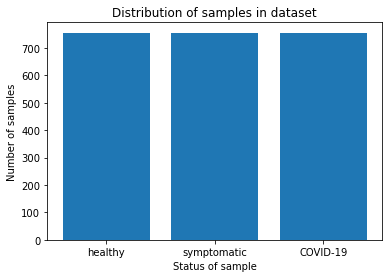

In [13]:
plot_label_distribution(equalized_df['status'].value_counts(), title='Distribution of samples in dataset')

# Appendix - Augmentation techniques

We used spectrogram augmentation techniques to increase the number of samples in the dataset. We used spectrogram masking both in the time and frequency domain, and we used pitch shifting. We tried different values for the mask values and the pitch shift values. We also tried different combinations of the augmentation techniques.

In [14]:
LENGTH = 10.0
SAMPLE_RATE = 16000

signal, sample_rate, info = AudioUtils.load_audio_file(covid_sample_uuid, DATA_PATH)

signal = AudioUtils.resample(signal, sample_rate, target_sample_rate=SAMPLE_RATE)
signal = AudioUtils.rechannel(signal, channels=1)

signal = AudioUtils.resize(signal, duration=LENGTH, sample_rate=SAMPLE_RATE)

print(f'Signal shape: {signal.shape}')

Signal shape: torch.Size([1, 160000])


### Spectrogram before augmentation

Spectrogram shape: torch.Size([1, 64, 313])


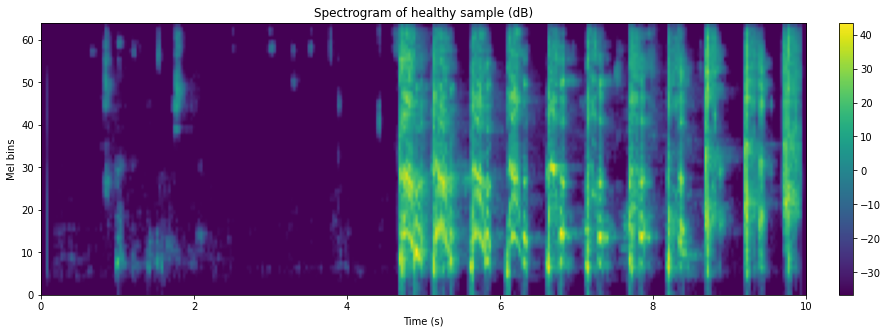

In [15]:
NUM_MEL_BINS = 64
NUM_FFTS = 1024

spectrogram = AudioUtils.get_spectrogram(signal, sample_rate=SAMPLE_RATE, n_mels=NUM_MEL_BINS, n_fft=NUM_FFTS)
print(f'Spectrogram shape: {spectrogram.shape}')

plot_audio_spectogram(spectrogram, LENGTH, title='Spectrogram of healthy sample (dB)')

## Applying time and frequency masking - `min` of the spectrogram

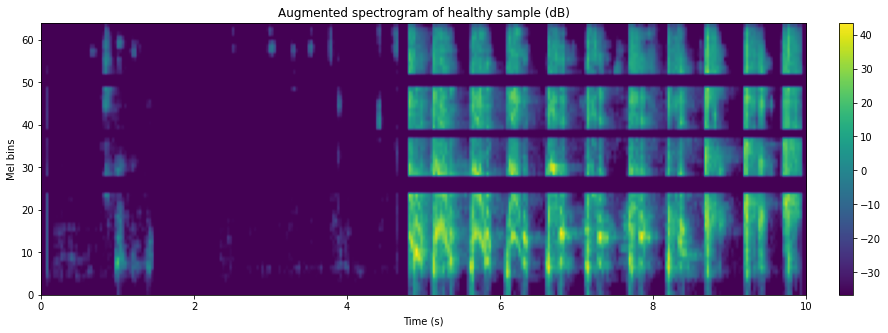

In [16]:
N_FREQ_MASKS = 3
N_TIME_MASKS = 2
MASKING_VAL = 'min'

masked_spectrogram = AudioUtils.spectrogram_masking(spectrogram, n_freq_masks=N_FREQ_MASKS, n_time_masks=N_TIME_MASKS, masking_val=MASKING_VAL)

plot_audio_spectogram(masked_spectrogram, LENGTH, title='Augmented spectrogram of healthy sample (dB)')

## Applying time and frequency masking - `mean` of the spectrogram

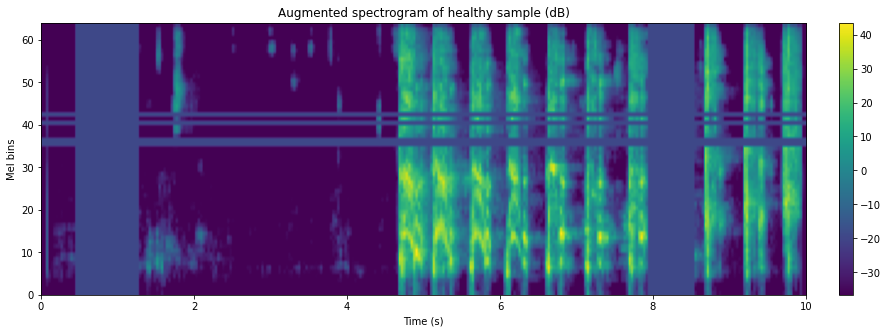

In [17]:
N_FREQ_MASKS = 3
N_TIME_MASKS = 2
MASKING_VAL = 'mean'

masked_spectrogram = AudioUtils.spectrogram_masking(spectrogram, n_freq_masks=N_FREQ_MASKS, n_time_masks=N_TIME_MASKS, masking_val=MASKING_VAL)

plot_audio_spectogram(masked_spectrogram, LENGTH, title='Augmented spectrogram of healthy sample (dB)')

## Applying pitch shifting to the signal

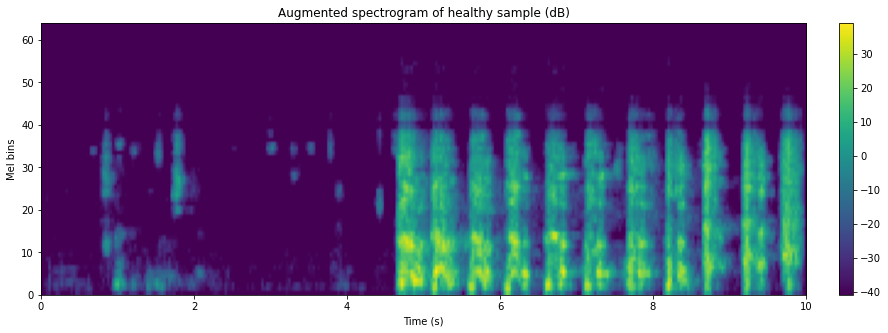

In [18]:
PITCH_SHIFT_MAX_VALUE = 20

pitched_signal = AudioUtils.signal_pitch_shift(signal, sample_rate=SAMPLE_RATE, pitch_max_value=PITCH_SHIFT_MAX_VALUE)
pitched_spectrogram = AudioUtils.get_spectrogram(pitched_signal, sample_rate=SAMPLE_RATE, n_mels=NUM_MEL_BINS, n_fft=NUM_FFTS)

plot_audio_spectogram(pitched_spectrogram, LENGTH, title='Augmented spectrogram of healthy sample (dB)')

## Combining all augmentation techniques

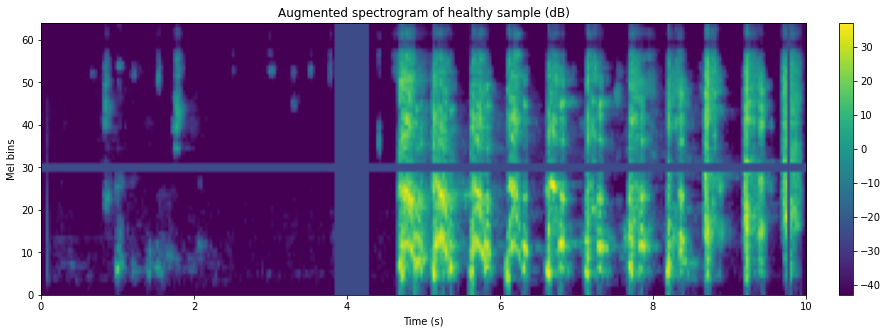

In [19]:
combined_singal = AudioUtils.signal_pitch_shift(signal, sample_rate=SAMPLE_RATE, pitch_max_value=PITCH_SHIFT_MAX_VALUE)
combined_spectrogram = AudioUtils.get_spectrogram(combined_singal, sample_rate=SAMPLE_RATE, n_mels=NUM_MEL_BINS, n_fft=NUM_FFTS)
combined_spectrogram = AudioUtils.spectrogram_masking(combined_spectrogram, n_freq_masks=N_FREQ_MASKS, n_time_masks=N_TIME_MASKS, masking_val=MASKING_VAL)

plot_audio_spectogram(combined_spectrogram, LENGTH, title='Augmented spectrogram of healthy sample (dB)')